In [1]:
# Include libraries
from ipywidgets import FloatProgress
from IPython.display import display
from warnings import simplefilter
import matplotlib.pyplot as plt
# Stop warnings from printing
simplefilter('ignore')
from copy import deepcopy
import numpy as np
import cpuinfo
import sys
import math
import os

# Load pytorch
import torch
import torchvision

In [2]:
from Scripts.pytorchHelpers import dataLoading, visual, devices
from Scripts import VGG16FCN

In [3]:
devices.assign()

Found 2 GPUs:
GPU 0: GeForce GTX 1070
GPU 1: GeForce GTX 1070


In [4]:
# Instance a FCN base on VGG16
FCN8 = VGG16FCN.FCN8(2)
# Build a collection of batch iomage loaders
loaders = dataLoading.buildDataloaders(24, 0.2, '\\Data\\data_road\\', 'training\\raw\\', 'training\\gt\\', 'testing\\')

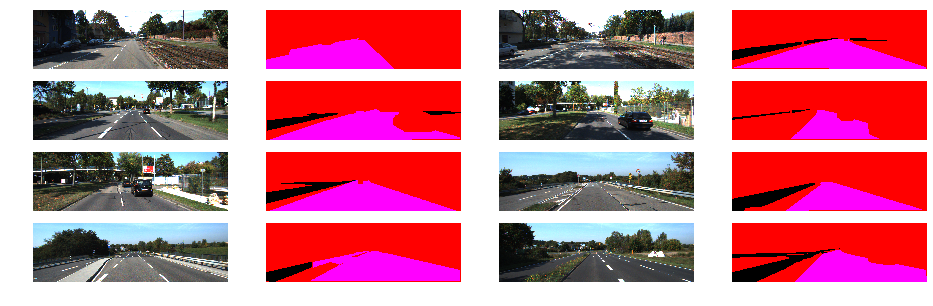

In [5]:
# Get current working directory
path =  os.getcwd() + "\Data\data_road"
pathRaw = path + "\\training\\raw\\image_2"
pathGroundTruth = path + "\\training\\gt\\gt_image_2"
groundTruthFiles = os.listdir(pathGroundTruth)
rawFiles = os.listdir(pathRaw)

# Print examples of the images
Figure = plt.figure(figsize=(16, 5))
for i in range(16):
    if (i % 2 != 0):
        tmpFilePath = pathGroundTruth + "\\" + groundTruthFiles[i]
    else:
        tmpFilePath = pathRaw + "\\" + rawFiles[i]
    
    tmpImage = plt.imread(tmpFilePath)
    Figure.add_subplot(4, 4, i+1).axis('off')
    plt.imshow(tmpImage)

0 torch.Size([24, 3, 375, 1242])
0 torch.Size([24, 3, 375, 1242])


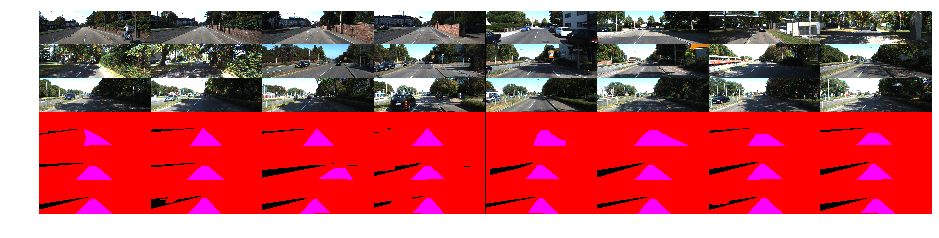

In [6]:
# Confirming that sequential loaders are working
for batch, gtrawBatched in enumerate(zip(loaders['train'], loaders['trainGT'])):
    print(batch, gtrawBatched[0][0].shape)
    print(batch, gtrawBatched[1][0].shape)
    # generate 2nd batch and display it
    if batch == 0:
        plt.figure(figsize=(16, 14))
        img = visual.tensorToNumpy(torch.cat((gtrawBatched[0][0], gtrawBatched[1][0])))
        plt.axis('off')
        plt.imshow(img)
        plt.savefig('Figures\\BatchExample.png')
        break 